In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


In [2]:
# 데이터 normalize 함수 설정
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# 딥러닝 네트워크 트레이닝할 데이터셋 설정
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# 트레이닝된 딥러닝 네트워크 테스트할 테이터
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# 이미지에 대한 라벨
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


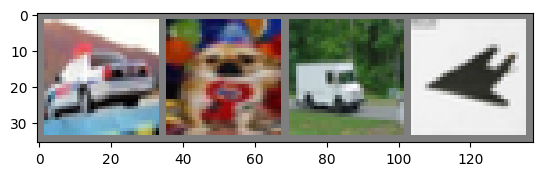

car   dog   truck plane


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [4]:
# 딥러닝 네트워크 설정
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #16
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #RGB 영상 3x32x32 -> 6x28x28 -> 6x14x14
        x = self.pool(F.relu(self.conv2(x))) #6x14x14 -> 6x10x10 -> 6x5x5
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x)) # 16x5x5 -> 120
        x = F.relu(self.fc2(x)) # 120 -> 84
        x = self.fc3(x) # 84 -> 10
        return x

# 3x32x32 영상을 받아서 10개의 class로 분류

net = Net()

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.199
[1,  4000] loss: 1.886
[1,  6000] loss: 1.684
[1,  8000] loss: 1.584
[1, 10000] loss: 1.504
[1, 12000] loss: 1.503
[2,  2000] loss: 1.408
[2,  4000] loss: 1.396
[2,  6000] loss: 1.369
[2,  8000] loss: 1.333
[2, 10000] loss: 1.310
[2, 12000] loss: 1.282
[3,  2000] loss: 1.216
[3,  4000] loss: 1.212
[3,  6000] loss: 1.200
[3,  8000] loss: 1.211
[3, 10000] loss: 1.188
[3, 12000] loss: 1.178
[4,  2000] loss: 1.102
[4,  4000] loss: 1.094
[4,  6000] loss: 1.104
[4,  8000] loss: 1.115
[4, 10000] loss: 1.108
[4, 12000] loss: 1.116
[5,  2000] loss: 1.030
[5,  4000] loss: 1.033
[5,  6000] loss: 1.030
[5,  8000] loss: 1.016
[5, 10000] loss: 1.048
[5, 12000] loss: 1.047
Finished Training


In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

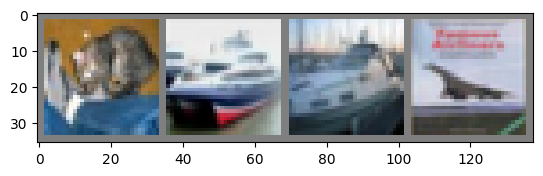

GroundTruth:  cat   ship  ship  plane


In [8]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   car   ship  ship 


In [10]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 58 %


In [11]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 68.7 %
Accuracy for class: car   is 75.2 %
Accuracy for class: bird  is 36.5 %
Accuracy for class: cat   is 29.6 %
Accuracy for class: deer  is 73.3 %
Accuracy for class: dog   is 53.3 %
Accuracy for class: frog  is 49.1 %
Accuracy for class: horse is 62.7 %
Accuracy for class: ship  is 70.5 %
Accuracy for class: truck is 64.5 %
